In [1]:
from mmdet.datasets import build_dataset
from mmdet.apis import multi_gpu_test, single_gpu_test
from mmdet.core import wrap_fp16_model
from mmdet.datasets import build_dataloader, build_dataset
from mmdet.models import build_detector
import mmcv
import torch
from mmcv import Config, DictAction
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmcv.runner import get_dist_info, init_dist, load_checkpoint
from mmcv.utils import print_log
import numpy as np
config = './configs/universenet/universenet50_fp16_4x4_mstrain_480_960_2x_coco.py'
checkpoint = 'work_dirs/universenet50_fp16_4x4_mstrain_480_960_2x_coco/epoch_26.pth'
cfg = Config.fromfile(config)

In [2]:
import pandas as pd
df = pd.read_csv('../data/train.csv')
bboxs = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    df[column] = bboxs[:,i]
df.drop(columns=['bbox'], inplace=True)
df['x2'] = df['x'] + df['w']
df['y2'] = df['y'] + df['h']
df['classes'] = 0
from tqdm.auto import tqdm
import shutil as sh
df = df[['image_id','x', 'y', 'w', 'h','x2','y2','classes']]

In [3]:
flip = False
if flip:
    print(cfg.data.test.pipeline[-1].flip)
    cfg.data.test.pipeline[-1].flip_direction = ['horizontal'] #["horizontal", "vertical"]
    cfg.data.test.pipeline[-1].flip = flip

In [4]:
score_thr = 0.45
if score_thr is not None:
    cfg.test_cfg.score_thr = score_thr
    if "min_score" in cfg.test_cfg.nms:
        cfg.test_cfg.nms.min_score = score_thr

In [5]:
iou_thr = 0.55
if iou_thr is not None:
    cfg.test_cfg.nms.iou_thr = iou_thr
        

In [6]:
cfg.data.test.test_mode = True

In [7]:
dataset = build_dataset(cfg.data.test)
distributed = False
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=distributed,
        shuffle=False,
    )

loading annotations into memory...
Done (t=0.31s)
creating index...
index created!


In [8]:
model = build_detector(cfg.model, train_cfg=None, test_cfg=cfg.test_cfg)

2020-07-14 17:58:00,458 - root - INFO - load model from: https://github.com/shinya7y/UniverseNet/releases/download/20.06/res2net50_v1b_26w_4s-3cf99910_mmdetv2.pth
2020-07-14 17:58:03,045 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

missing keys in source state_dict: layer2.0.convs.0.conv_offset.weight, layer2.0.convs.0.conv_offset.bias, layer2.0.convs.1.conv_offset.weight, layer2.0.convs.1.conv_offset.bias, layer2.0.convs.2.conv_offset.weight, layer2.0.convs.2.conv_offset.bias, layer2.1.convs.0.conv_offset.weight, layer2.1.convs.0.conv_offset.bias, layer2.1.convs.1.conv_offset.weight, layer2.1.convs.1.conv_offset.bias, layer2.1.convs.2.conv_offset.weight, layer2.1.convs.2.conv_offset.bias, layer2.2.convs.0.conv_offset.weight, layer2.2.convs.0.conv_offset.bias, layer2.2.convs.1.conv_offset.weight, layer2.2.convs.1.conv_offset.bias, layer2.2.convs.2.conv_offset.weight, layer2.2.convs.2.conv_offset.bias,

In [9]:
checkpoint = load_checkpoint(model, checkpoint, map_location="cpu")

In [10]:
if "CLASSES" in checkpoint["meta"]:
        model.CLASSES = checkpoint["meta"]["CLASSES"]
else:
        model.CLASSES = dataset.CLASSES


In [11]:
df.head()

,image_id,x,y,w,h,x2,y2,classes
0,b6ab77fd7,834.0,222.0,56.0,36.0,890.0,258.0,0
1,b6ab77fd7,226.0,548.0,130.0,58.0,356.0,606.0,0
2,b6ab77fd7,377.0,504.0,74.0,160.0,451.0,664.0,0
3,b6ab77fd7,834.0,95.0,109.0,107.0,943.0,202.0,0
4,b6ab77fd7,26.0,144.0,124.0,117.0,150.0,261.0,0


In [12]:
from utils_test import *
iou_thresholds = []
for x in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75]:
    iou_thresholds.append(x)
def calculate_image_precision(gts, preds, thresholds = iou_thresholds, form = 'pascal_voc'):
    n_threshold = 6
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1


    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

In [13]:
from tqdm.auto import tqdm
model = MMDataParallel(model, device_ids=[0])
show = False
show_dir = None
show_score_thr=0.3
model.eval()
results = []
GT = []
dataset = data_loader.dataset
ids = []
scores = []
tqdm_loder = tqdm(data_loader)
for i, data in enumerate(tqdm_loder):
    with torch.no_grad():
        result = model(return_loss=False, rescale=not show, **data)
    id0 = data['img_metas'][0].data[0][0]['ori_filename'].split(".jpg")[0]
    ids.append(data['img_metas'][0].data[0][0]['filename']) 
    gt = df[df.image_id==id0][['x','y','x2','y2']].values
    GT.append(gt)
    results.append(result[0])
    batch_size = data['img'][0].size(0)
    boxes = results[i]
    bboes_gt = GT[i]
    score = calculate_image_precision(bboes_gt,boxes[:,:4])
    scores.append(score)
    tqdm_loder.set_description(str(np.mean(scores)))

0.6003586999286519


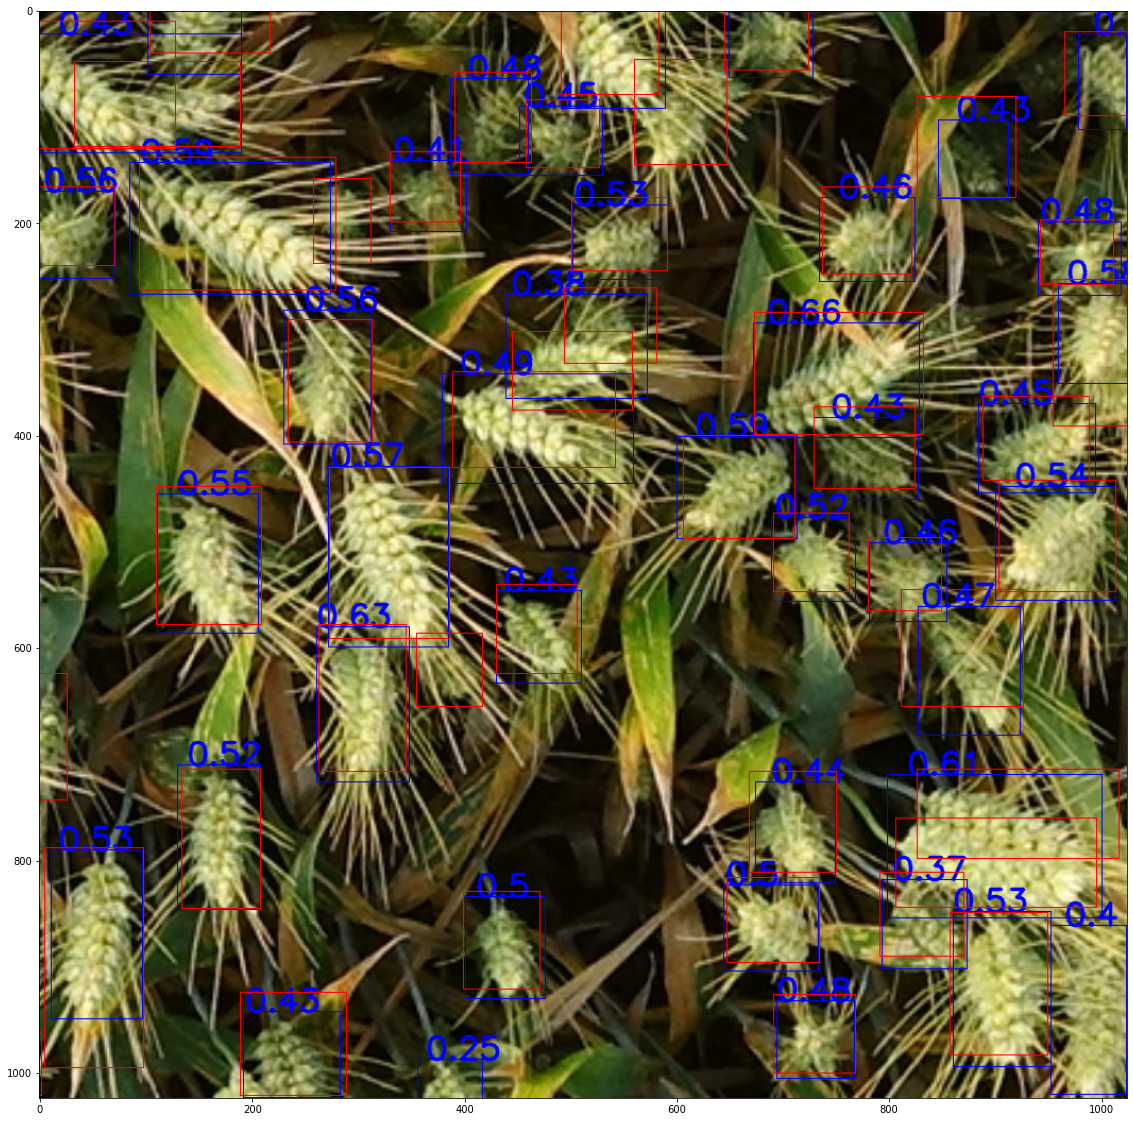

In [14]:
from matplotlib import pyplot as plt
import cv2
size = 300
idx =168
font = cv2.FONT_HERSHEY_SIMPLEX 
image = cv2.imread(ids[idx], cv2.IMREAD_COLOR)
# fontScale 
fontScale = 1
# boxes = all_bboxex[idx]
# scores = all_score[idx]
# Blue color in BGR 
color = (255, 0, 0) 
boxes = results[idx]
bboes_gt = GT[idx]
print(calculate_image_precision(bboes_gt,boxes[:,:4]))
# Line thickness of 2 px 
thickness = 2
for b in boxes:
    s = b[-1].copy()
    b = b.astype(int)
    image = cv2.rectangle(image, (b[0],b[1]), (b[2],b[3]), (255,0,0), 1) 
    image = cv2.putText(image, '{:.2}'.format(s), (b[0]+np.random.randint(20),b[1]), font,  
                   fontScale, color, thickness, cv2.LINE_AA)
for b in bboes_gt:
    b = b.astype(int)
    image = cv2.rectangle(image, (b[0],b[1]), (b[2],b[3]), (0,0,255), 1) 
plt.figure(figsize=[20,20])
plt.imshow(image[:,:,::-1])
plt.show()

<IPython.core.display.Javascript object>


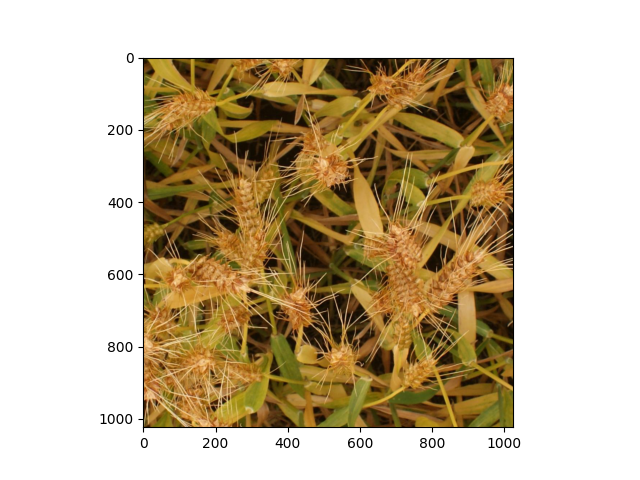

In [15]:
%matplotlib notebook
# plt.figure(figsize=[20,20])
plt.imshow(plt.imread("../data/test/796707dd7.jpg"))